# NPL Natural Disasters

In [1]:
%%capture

import collections
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

import spacy
# import scattertext as st

from unidecode import unidecode

from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    classification_report,
)

from sklearn.model_selection import train_test_split, cross_val_score

import nltk
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.metrics.distance import jaccard_distance
from nltk.util import ngrams
from nltk.corpus import stopwords
from nltk.corpus import words
from nltk.stem import WordNetLemmatizer

nltk.download("wordnet")
nltk.download("omw-1.4")
nltk.download("punkt")
nltk.download("words")
nltk.download("stopwords")


!python -m spacy download en_core_web_sm
# !python -m spacy download en_core_web_trf


2022-12-03 06:51:51.679510: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-12-03 06:51:51.713694: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


In [2]:
# load datasets

df_train = pd.read_csv("data/train.csv")
df_train["train"] = 1
df_test = pd.read_csv("data/test.csv")
df_test["train"] = 0
df = pd.concat([df_train, df_test], axis=0)
df


,id,keyword,location,text,target,train
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1.0,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1.0,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1.0,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1.0,1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1.0,1
...,...,...,...,...,...,...
3258,10861,NaN,NaN,EARTHQUAKE SAFETY LOS ANGELES ÛÒ SAFETY FASTE...,NaN,0
3259,10865,NaN,NaN,Storm in RI worse than last hurricane. My city...,NaN,0
3260,10868,NaN,NaN,Green Line derailment in Chicago http://t.co/U...,NaN,0
3261,10874,NaN,NaN,MEG issues Hazardous Weather Outlook (HWO) htt...,NaN,0


## Data Cleaning

In [3]:
# perform data cleaning

# 1. convert all letters to lowercase, so capitalization does not influence word frequency
df["text_cleaned"] = df["text"].str.lower()

# 2. remove @mention
df["text_cleaned"] = df["text_cleaned"].str.replace("@\w+|.@\w+", "", regex=True)

# 3. remove emoji
# credit: https://stackoverflow.com/questions/33404752/removing-emojis-from-a-string-in-python
df["text_cleaned"] = df["text_cleaned"].str.replace(
    "\U0001F600-\U0001F64F", "", regex=True
)
df["text_cleaned"] = df["text_cleaned"].str.replace(
    "\U0001F300-\U0001F5FF", "", regex=True
)
df["text_cleaned"] = df["text_cleaned"].str.replace(
    "\U0001F680-\U0001F6FF", "", regex=True
)
df["text_cleaned"] = df["text_cleaned"].str.replace(
    "\U0001F680-\U0001F6FF", "", regex=True
)

# 4. remove non alphabetical characters
df["text_cleaned"] = df["text_cleaned"].str.replace("/[^\x00-\x7F]+/", "", regex=True)

# 4. remove special character referencing starting with &
df["text_cleaned"] = df["text_cleaned"].str.replace("&[a-z]+;?", "", regex=True)

# 5. remove http and https links
df["text_cleaned"] = df["text_cleaned"].str.replace(
    "((?:http|https):\/\/[-\w\d+=&@#\/%?~|!:;\.,]*)", "", regex=True
)

# 6. remove punctuations with a space, except for apostrophes
# note that many text do not have space after punctuations, to prevent joining separate words, replace with space
df["text_cleaned"] = df["text_cleaned"].str.replace("[^\w\s']", " ", regex=True)

# 7. translate non ascii text to closest representation
# credit: https://stackoverflow.com/questions/517923/what-is-the-best-way-to-remove-accents-normalize-in-a-python-unicode-string
df["text_cleaned"] = df["text_cleaned"].apply(lambda x: unidecode(x))

# 8. remove blocks of numbers
df["text_cleaned"] = df["text_cleaned"].str.replace("\d+", " ", regex=True)

# 9. remove extra white spaces before after sentences, as well as between words
df["text_cleaned"] = df["text_cleaned"].str.replace("\s+", " ", regex=True)

# 10. remove misc bad letters or invalid letter blocks
df["text_cleaned"] = df["text_cleaned"].str.replace("u_", " ")

# 11. finally stripe all leading and ending whitespaces and numbers
df["text_cleaned"] = df["text_cleaned"].str.strip("123.!? \n\t")


After the above 9 simple data cleaning, most of our tweets are free of invalid characters and text strings. There are still two issues remain:

* **misspelling of words**: a number of words provided in the dataset had been misspelled. Without correcting word spelling, the misspelled words will likely be either discarded during feature engineering and selection, and have little predictive power if included.
* **retweets and nearly identical tweets**: identical tweets and retweets can bias the dataset toward a specific set of words and phrases. It's better if identical copy or very similar tweets are removed.


In [4]:
# # To fix mispelling of words, we cab use jaccard_distance.
# def sentenceSpellCorrect(sentence):

#     # credit: https://www.geeksforgeeks.org/correcting-words-using-nltk-in-python/
#     # list of incorrect spellings
#     # that need to be corrected
#     check_words = sentence.split(" ")
#     new_words = []

#     # loop for finding correct spellings
#     # based on jaccard distance
#     # and printing the correct word
#     for word in check_words:
#         try:
#             temp = [
#                 (jaccard_distance(set(ngrams(word, 2)), set(ngrams(w, 2))), w)
#                 for w in correct_words
#                 if w[0] == word[0]
#             ]
#             new = sorted(temp, key=lambda val: val[0])[0][1]
#             if word != new:
#                 print(f"{word} has been corrected to {new}")
#             new_words.append(new)

#         except:
#             print(f"error occurred when processing sentence: '{sentence}'")
#     new_sentence = " ".join(new_words)
#     return new_sentence


# global correct_words
# correct_words = words.words()
# df["text_cleaned"] = df["text_cleaned"].apply(lambda x: sentenceSpellCorrect(x))


at the end of data cleaning, separate test and train datasets


In [5]:
df_train = df[df.train == 1]
df_train.head(5)


,id,keyword,location,text,target,train,text_cleaned
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1.0,1,our deeds are the reason of this earthquake ma...
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1.0,1,forest fire near la ronge sask canada
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1.0,1,all residents asked to 'shelter in place' are ...
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1.0,1,people receive wildfires evacuation orders in ...
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1.0,1,just got sent this photo from ruby alaska as s...


In [6]:
df_test = df[df.train == 0]
df_test.head(5)


,id,keyword,location,text,target,train,text_cleaned
0,0,NaN,NaN,Just happened a terrible car crash,NaN,0,just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s...",NaN,0,heard about earthquake is different cities sta...
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are...",NaN,0,there is a forest fire at spot pond geese are ...
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires,NaN,0,apocalypse lighting spokane wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan,NaN,0,typhoon soudelor kills in china and taiwan


In [7]:
# for the rest of the project, we will no longer be using df_test, so set df_train to df
df = df_train


## Task 1: Bag of words model

### 1A. Build bag of words / unigrams (Feature Engineering)

In [8]:
# iterate through the entire training df and build bag of words (tokens) for target == 1 and target == 0

bag_target_0 = []
for sentence in list(df[df.target == 0]["text_cleaned"]):
    tokens = word_tokenize(sentence)
    bag_target_0 = bag_target_0 + tokens

bag_target_1 = []
for sentence in list(df[df.target == 1]["text_cleaned"]):
    tokens = word_tokenize(sentence)
    bag_target_1 = bag_target_1 + tokens


In [9]:
# perform preprocessing to further clean the word list

# three main preprocessing are done on tokens or word list
# 1. remove non alphanumeric characters or symbols that slip through data cleaning
# 2. remove any stop words like the, a, etc. that are present for grammatical reasons and are semantically meaningful
# 3. convert similar words together via Lemmatization, such that the base word is used
wordnet = WordNetLemmatizer()

bag_target_0_processed = bag_target_0
bag_target_0_processed = [i for i in bag_target_0_processed if i.isalpha()]
bag_target_0_processed = [
    i for i in bag_target_0_processed if i not in stopwords.words("english")
]
bag_target_0_processed = [wordnet.lemmatize(i) for i in bag_target_0_processed]
count_bag_target_0_processed = collections.Counter(bag_target_0_processed)
# count_bag_target_0_processed.most_common(10)

bag_target_1_processed = bag_target_1
bag_target_1_processed = [i for i in bag_target_1_processed if i.isalpha()]
bag_target_1_processed = [
    i for i in bag_target_1_processed if i not in stopwords.words("english")
]
bag_target_1_processed = [wordnet.lemmatize(i) for i in bag_target_1_processed]
count_bag_target_1_processed = collections.Counter(bag_target_1_processed)
# count_bag_target_1_processed.most_common(10)


In [10]:
# compute frequency of bag of words

count_bag_target_0_processed = dict(
    zip(count_bag_target_0_processed.keys(), count_bag_target_0_processed.values())
)
count_bag_target_1_processed = dict(
    zip(count_bag_target_1_processed.keys(), count_bag_target_1_processed.values())
)

df_bag_target_0 = pd.DataFrame(
    list(count_bag_target_0_processed.items()), columns=["word", "count"]
)
df_bag_target_1 = pd.DataFrame(
    list(count_bag_target_1_processed.items()), columns=["word", "count"]
)

df_bag_target_0["freq"] = df_bag_target_0["count"] / df_bag_target_0["count"].sum()
df_bag_target_1["freq"] = df_bag_target_1["count"] / df_bag_target_1["count"].sum()

df_bag_target_0 = df_bag_target_0.sort_values(by="count", ascending=False)
df_bag_target_0 = df_bag_target_0.reset_index(drop=True)
df_bag_target_1 = df_bag_target_1.sort_values(by="count", ascending=False)
df_bag_target_1 = df_bag_target_1.reset_index(drop=True)


review word count of 10 most common words for non-disaster tweets

In [11]:
df_bag_target_0.head(10)


,word,count,freq
0,like,256,0.007152
1,u,214,0.005978
2,get,184,0.005140
3,new,170,0.004749
4,one,138,0.003855
5,body,117,0.003269
6,time,106,0.002961
7,would,105,0.002933
8,day,104,0.002905
9,video,102,0.002849


review word count of 10 most common words for disaster tweets

In [12]:
df_bag_target_1.head(10)


,word,count,freq
0,fire,266,0.008747
1,u,162,0.005327
2,news,148,0.004867
3,disaster,122,0.004012
4,via,121,0.003979
5,year,112,0.003683
6,california,111,0.003650
7,police,109,0.003584
8,suicide,106,0.003486
9,family,105,0.003453


### 1B. Feature selection

Remove low sample rate features

In [13]:
# to start, remove low occurrence words
# these words occurs so rarely that they have little predictive power

bag_words = bag_target_0_processed + bag_target_1_processed
count_bag_words = collections.Counter(bag_words)

count_bag_words = dict(zip(count_bag_words.keys(), count_bag_words.values()))
df_bag_words = pd.DataFrame(list(count_bag_words.items()), columns=["word", "count"])
LOW_OCCURRENCE_THRESHOLD = 1
df_bag_words = df_bag_words[df_bag_words["count"] > LOW_OCCURRENCE_THRESHOLD]


In [14]:
# build training dataset using bag of words
def buildFeaturesFromWords(df, df_text_col, word_list):
    df = df.copy()
    series_list = []
    for word in word_list:
        # count number of this word in the sentence text
        if len(word) > 1:
            # discard single letter words
            s = df[df_text_col].str.count(word).rename(f"_{word}")
            series_list.append(s)
    return pd.concat([df, pd.concat(series_list, axis=1)], axis=1)


unique_words = list(df_bag_words.word.unique())
# make sure the unique word list is smaller than separate bags
assert (len(df_bag_target_0) + len(df_bag_target_1)) > len(unique_words)

df = buildFeaturesFromWords(df=df, df_text_col="text_cleaned", word_list=unique_words)

# build a list of variable names that correspond to df columns
unigram_list = [f"_{i}" for i in unique_words if len(i) > 1]

df.head(5)


,id,keyword,location,text,target,train,text_cleaned,_man,_love,_fruit,...,_idfire,_scariest,_ekiti,_salvadoran,_exchanging,_exc,_fatally,_ushed,_kashmir,_woodlawn
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1.0,1,our deeds are the reason of this earthquake ma...,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1.0,1,forest fire near la ronge sask canada,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1.0,1,all residents asked to 'shelter in place' are ...,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1.0,1,people receive wildfires evacuation orders in ...,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1.0,1,just got sent this photo from ruby alaska as s...,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Remove variables based on variance threshold

In [15]:
pred_var = "target"
X, y = df[unigram_list], df_train[pred_var]


In [16]:
from sklearn.feature_selection import VarianceThreshold

LOW_VAR_THRESHOLD = 0.005
sel = VarianceThreshold(threshold=LOW_VAR_THRESHOLD)
sel.fit(X)
# print(sel.get_feature_names_out())
print(
    f"by applying a low variance threshold of {LOW_VAR_THRESHOLD}, {len(unigram_list) - len(sel.get_feature_names_out())} out of {len(unigram_list)} variables were removed"
)

selected_unigram_list = list(sel.get_feature_names_out())


by applying a low variance threshold of 0.005, 4668 out of 5626 variables were removed


In [17]:
pred_var = "target"
X, y = df[selected_unigram_list], df_train[pred_var]


### 1C. Logistic regression model

In [18]:
from sklearn import linear_model

X_train, X_test, y_train, y_test = train_test_split(
    X, y, random_state=0, train_size=0.8
)
reg = linear_model.LogisticRegression(solver="lbfgs", max_iter=1000)
reg.fit(X_train, y_train)
y_pred = reg.predict(X_test)
print(f"score: {accuracy_score(y_test, y_pred)}")
print(classification_report(y_test, y_pred, target_names=["disaster", "normal"]))


score: 0.7721602101116218
              precision    recall  f1-score   support

    disaster       0.78      0.84      0.81       886
      normal       0.76      0.67      0.71       637

    accuracy                           0.77      1523
   macro avg       0.77      0.76      0.76      1523
weighted avg       0.77      0.77      0.77      1523



In [19]:
y_pred_within = reg.predict(X_train)
cm = confusion_matrix(y_train, y_pred_within)

print("Confusion matrix for within sample predictions (percentage):")
print(cm / cm.sum() * 100)


Confusion matrix for within sample predictions (percentage):
[[51.55993432  5.18883415]
 [ 9.44170772 33.80952381]]


In [20]:
cm = confusion_matrix(y_test, y_pred)

print("Confusion matrix for out of sample predictions")
print(cm / cm.sum() * 100)


Confusion matrix for out of sample predictions
[[49.04793171  9.12672357]
 [13.65725542 28.1680893 ]]


The simple logistic regression model using bag of words features performed reasonably well. However, the confusion matrix for out of sample prediction is noticeably worse than within sample prediction. This can be an indication of overfitting.

Additional effort in using cross validation methods (k-fold), and regularization method (ridge classification) that is more robust to overfitting can reduce model overfitting.

In [21]:
#  evaluate and plot the model

df.loc[df["target"] == 0, "target_name"] = "Normal"
df.loc[df["target"] == 1, "target_name"] = "Disaster"

# generate probability for all samples for plotting
y_pred_all = reg.predict_proba(X)
df["prob_1"] = y_pred_all[:, 1]


In [22]:
# this code block has error

# from scattertext import CorpusFromPandas, produce_scattertext_explorer

# nlp = spacy.load("en_core_web_sm")
# corpus = st.CorpusFromPandas(
#     df.sample(1000), category_col="target_name", text_col="text_cleaned", nlp=nlp
# ).build()

# html = st.produce_scattertext_explorer(
#     corpus,
#     category="target_name",
#     category_name="Disaster",
#     not_category_name="Normal",
#     width_in_pixels=1000,
#     minimum_term_frequency=0,
#     transform=st.Scalers.scale,
#     # metadata=df['speaker']
# )
# file_name = "Conventions2012ScattertextScale.html"
# open(file_name, "wb").write(html.encode("utf-8"))
# IFrame(src=file_name, width=1200, height=700)


In [23]:
df["text_short"] = df["text_cleaned"].str.slice(0, 6)


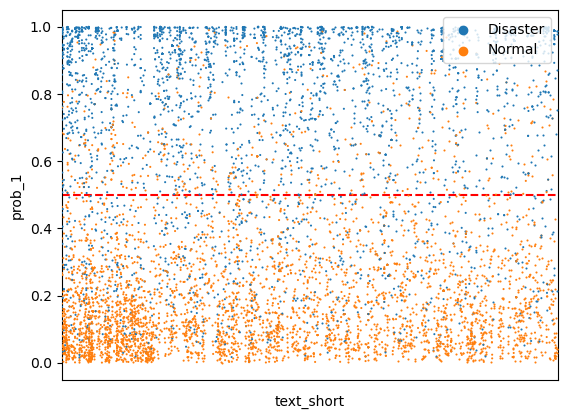

In [24]:
fig = sns.stripplot(df, x="text_short", y="prob_1", hue="target_name", size=1.5)
# fig.set(xlabel=None)
fig.set(xticklabels=[])
fig.tick_params(bottom=False)
plt.axhline(y=0.5, color="red", linestyle="--")
plt.legend(loc="upper right")


There are quite a large number of misclassification with the simple Logistic Regression model with bag of words. We can further improve upon this method by accounting for the importance of words in the dataset using Term Frequency and Inverse Document Frequency (TF-IDF).

## Task 2: Feature generation and traditional ML model with TF-IDF

In [25]:
# clean up dataframe to have the cleaned text, target, and full list of unigram
df = df[["id", "keyword", "location", "text_cleaned", "target"]]
df.shape


(7613, 5631)

### 2A. Build ngrams with TF-IDF (Feature Engineering)

In addition to the issue of weighting with bag of words, the use of unigram also means the feature lacks context. For Task 2 with TF-IDF, in addition to unigram, bigrams are generated as a set of features to enhance the ability of models to capture context.

For task 2, the TfidfVectorizer from sklearn is used to generate both ngrams and the TF-IDF score.

_About TF-IDF Score_

TF = (Count of this word in the document) / (Total number of words in the document)
IDF = log {(Total number of document) / [(Number of document containing the word) + 1]}

TF-IDF = TF * IDF

In [51]:
from sklearn.feature_extraction.text import TfidfVectorizer
from time import time

vectorizer = TfidfVectorizer(
    max_df=0.5,
    min_df=5,
    ngram_range=(1,2), # unigrams and bigrams
    stop_words="english",
)
t0 = time()
X_tfidf = vectorizer.fit_transform(df.text_cleaned)

print(f"vectorization done in {time() - t0:.3f} s")
print(f"n_samples: {X_tfidf.shape[0]}, n_features: {X_tfidf.shape[1]}")

vectorization done in 0.097 s
n_samples: 7613, n_features: 3354


In [52]:
vectorizer.get_feature_names_out()

array(['aba', 'aba woman', 'abandoned', ..., 'zionist', 'zombie', 'zone'],
      dtype=object)

To prevent overfitting, we reduce the number of features by setting a higher low variance threshold for bigrams.

In [54]:
# perform feature selection

from sklearn.feature_selection import VarianceThreshold

LOW_VAR_THRESHOLD = 0.0001
sel = VarianceThreshold(threshold=LOW_VAR_THRESHOLD)
sel.fit(X_tfidf)
X_tfidf = sel.transform(X_tfidf)
# print(sel.get_feature_names_out())
print(
    f"by applying a low variance threshold of {LOW_VAR_THRESHOLD}, {len(vectorizer.get_feature_names_out()) - len(sel.get_feature_names_out())} out of {len(vectorizer.get_feature_names_out())} ngram variables were removed"
)

selected_ngram_list = list(sel.get_feature_names_out())

print(f"length of selected_ngram_list: {len(selected_ngram_list)}")


by applying a low variance threshold of 0.0001, 629 out of 3354 ngram variables were removed
length of selected_ngram_list: 2725


### 2B. Logistic regression model

In [55]:
y = df_train[pred_var]

X_tfidf.shape

(7613, 2725)

In [56]:
from sklearn import linear_model

X_train, X_test, y_train, y_test = train_test_split(
    X_tfidf, y, random_state=0, train_size=0.8
)
reg = linear_model.LogisticRegression(solver="lbfgs", max_iter=1000)
reg.fit(X_train, y_train)
y_pred = reg.predict(X_test)
print(f"score: {accuracy_score(y_test, y_pred)}")
print(classification_report(y_test, y_pred, target_names=["disaster", "normal"]))


score: 0.7951411687458962
              precision    recall  f1-score   support

    disaster       0.78      0.90      0.84       886
      normal       0.82      0.65      0.73       637

    accuracy                           0.80      1523
   macro avg       0.80      0.78      0.78      1523
weighted avg       0.80      0.80      0.79      1523



In [57]:
y_pred_within = reg.predict(X_train)
cm = confusion_matrix(y_train, y_pred_within)

print("Confusion matrix for within sample predictions (percentage):")
print(cm / cm.sum() * 100)


Confusion matrix for within sample predictions (percentage):
[[53.4318555   3.31691297]
 [10.47619048 32.77504105]]


In [58]:
cm = confusion_matrix(y_test, y_pred)

print("Confusion matrix for out of sample predictions")
print(cm / cm.sum() * 100)


Confusion matrix for out of sample predictions
[[52.19960604  5.97504924]
 [14.51083388 27.31451083]]


In [59]:
#  evaluate and plot the model

df.loc[df["target"] == 0, "target_name"] = "Normal"
df.loc[df["target"] == 1, "target_name"] = "Disaster"

# generate probability for all samples for plotting
y_pred_all = reg.predict_proba(X_tfidf)
df["prob_1"] = y_pred_all[:, 1]


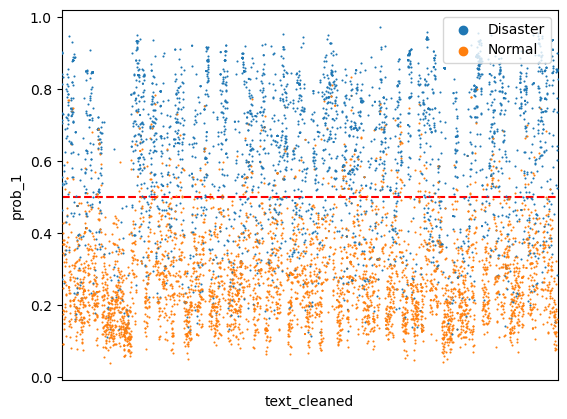

In [60]:
fig = sns.stripplot(df, x="text_cleaned", y="prob_1", hue="target_name", size=1.5)
# fig.set(xlabel=None)
fig.set(xticklabels=[])
fig.tick_params(bottom=False)
plt.axhline(y=0.5, color="red", linestyle="--")
plt.legend(loc="upper right")


Unfortunately, ngrams with unigrams and bigrams performed worse than the simple unigram model in section 1C. This could be due to the fact that most bigrams don't add enough useful information to each feature to justify the larger feature space, resulting in additional noise in the model.

### 3C. Repeat experiment with Unigram and TF-IDF, and logistic regression

In [61]:
from sklearn.feature_extraction.text import TfidfVectorizer
from time import time

vectorizer = TfidfVectorizer(
    max_df=0.5,
    min_df=5,
    ngram_range=(1,1), # unigrams only
    stop_words="english",
)
t0 = time()
X_tfidf = vectorizer.fit_transform(df.text_cleaned)

print(f"vectorization done in {time() - t0:.3f} s")
print(f"n_samples: {X_tfidf.shape[0]}, n_features: {X_tfidf.shape[1]}")

vectorization done in 0.059 s
n_samples: 7613, n_features: 2464


In [62]:
from sklearn import linear_model

X_train, X_test, y_train, y_test = train_test_split(
    X_tfidf, y, random_state=0, train_size=0.8
)
reg = linear_model.LogisticRegression(solver="lbfgs", max_iter=1000)
reg.fit(X_train, y_train)
y_pred = reg.predict(X_test)
print(f"score: {accuracy_score(y_test, y_pred)}")
print(classification_report(y_test, y_pred, target_names=["disaster", "normal"]))


score: 0.799080761654629
              precision    recall  f1-score   support

    disaster       0.79      0.90      0.84       886
      normal       0.82      0.66      0.73       637

    accuracy                           0.80      1523
   macro avg       0.80      0.78      0.79      1523
weighted avg       0.80      0.80      0.79      1523



In [64]:
y_pred_within = reg.predict(X_train)
cm = confusion_matrix(y_train, y_pred_within)

print("Confusion matrix for within sample predictions (percentage):")
print(cm / cm.sum() * 100)


Confusion matrix for within sample predictions (percentage):
[[53.46469622  3.28407225]
 [10.42692939 32.82430213]]


In [65]:
cm = confusion_matrix(y_test, y_pred)

print("Confusion matrix for out of sample predictions")
print(cm / cm.sum() * 100)


Confusion matrix for out of sample predictions
[[52.13394616  6.04070913]
 [14.05121471 27.77413001]]


In [66]:
#  evaluate and plot the model

df.loc[df["target"] == 0, "target_name"] = "Normal"
df.loc[df["target"] == 1, "target_name"] = "Disaster"

# generate probability for all samples for plotting
y_pred_all = reg.predict_proba(X_tfidf)
df["prob_1"] = y_pred_all[:, 1]


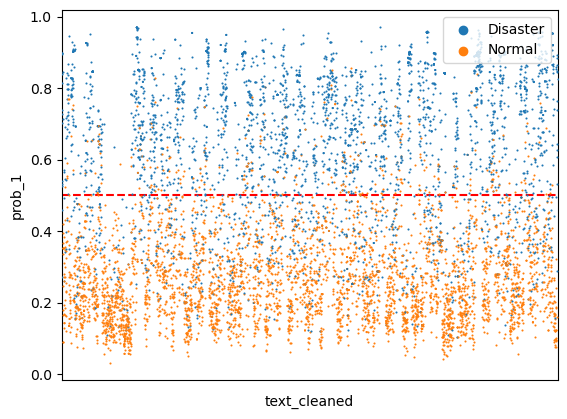

In [67]:
fig = sns.stripplot(df, x="text_cleaned", y="prob_1", hue="target_name", size=1.5)
# fig.set(xlabel=None)
fig.set(xticklabels=[])
fig.tick_params(bottom=False)
plt.axhline(y=0.5, color="red", linestyle="--")
plt.legend(loc="upper right")


The unigram version of tf-idf actually performed very similarly.

## Task 3: Pre-trained word embeddings + linear classifier model

### 3A. Use pre-trained GloVe embeddings to generate features

In [147]:
import torch
import torchtext

OSError: /home/coder/conda/envs/kaggle/lib/python3.9/site-packages/torchtext/lib/libtorchtext.so: undefined symbol: _ZNK5torch3jit6MethodclESt6vectorIN3c106IValueESaIS4_EERKSt13unordered_mapISsS4_St4hashISsESt8equal_toISsESaISt4pairIKSsS4_EEE

In [70]:
%%capture

import tensorflow as tf
from tensorflow import keras

# !wget http://nlp.stanford.edu/data/glove.6B.zip
# !unzip -q glove.6B.zip

# credit to example: https://keras.io/examples/nlp/pretrained_word_embeddings/

In [76]:
df['rand'] = np.random.rand(len(df))

In [98]:
train_words = df[df.rand>0.2].text_cleaned
test_words = df[df.rand<=0.2].text_cleaned
train_labels = df[df.rand>0.2].target
test_labels = df[df.rand<=0.2].target


In [99]:
train_words.shape

(6080,)

We do not perform text vectorization, since we want to map each instance into a single embedding.

In [156]:


# from tensorflow.keras.layers import TextVectorization

# vectorizer = TextVectorization(max_tokens=20000, output_sequence_length=100)
# text_ds = tf.data.Dataset.from_tensor_slices(train_words).batch(128)
# vectorizer.adapt(text_ds)

# # vectorizer.get_vocabulary()[:5]

# voc = vectorizer.get_vocabulary()
# word_index = dict(zip(voc, range(len(voc))))

# x_train = vectorizer(np.array([[s] for s in train_words])).numpy()
# x_val = vectorizer(np.array([[s] for s in test_words])).numpy()

# y_train = np.array(train_labels)
# y_val = np.array(test_labels)

In [164]:
# train_words[0]

In [165]:
# x_train[0]

In [167]:
# use our cleaned text to build a word index

word_index = dict(zip(list(df.text_cleaned), range(len(df))))

In [160]:
# read glove word embeddings

path_to_glove_file = os.path.join("./data/glove.6B.100d.txt")

embeddings_index = {}
with open(path_to_glove_file) as f:
    for line in f:
        word, coefs = line.split(maxsplit=1)
        coefs = np.fromstring(coefs, "f", sep=" ")
        embeddings_index[word] = coefs

In [168]:
# build an embedding matrix

num_tokens = len(voc) + 2
embedding_dim = 100
hits = 0
misses = 0

# Prepare embedding matrix
embedding_matrix = np.zeros((num_tokens, embedding_dim))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # Words not found in embedding index will be all-zeros.
        # This includes the representation for "padding" and "OOV"
        embedding_matrix[i] = embedding_vector
        hits += 1
    else:
        misses += 1
print("Converted %d words (%d misses)" % (hits, misses))

Converted 22 words (6806 misses)


In [162]:
# use the prepared embedding matrix to create an embedding layer

from tensorflow.keras.layers import Embedding

embedding_layer = Embedding(
    num_tokens,
    embedding_dim,
    embeddings_initializer=keras.initializers.Constant(embedding_matrix),
    trainable=False,
)

In [163]:
embedding_layer(x_train)

<tf.Tensor: shape=(6080, 100, 100), dtype=float32, numpy=
array([[[-8.5462e-02,  1.1468e-01,  6.3305e-01, ..., -2.5772e-01,
          5.7399e-01,  1.4787e+00],
        [ 4.3133e-01, -8.8912e-02, -6.1450e-02, ..., -2.4217e-01,
         -5.3863e-01, -1.3046e-01],
        [-5.1533e-01,  8.3186e-01,  2.2457e-01, ..., -1.2024e+00,
          1.1304e+00,  3.4790e-01],
        ...,
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00, ...,  0.0000e+00,
          0.0000e+00,  0.0000e+00],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00, ...,  0.0000e+00,
          0.0000e+00,  0.0000e+00],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00, ...,  0.0000e+00,
          0.0000e+00,  0.0000e+00]],

       [[-5.1682e-01,  4.9154e-01,  6.6964e-01, ...,  2.6521e-02,
          3.1274e-01, -9.5346e-01],
        [-2.6872e-01, -1.5542e-01, -2.3565e-01, ...,  4.9344e-01,
          7.2114e-01, -4.1749e-02],
        [-3.1416e-01, -7.0232e-01,  3.4693e-01, ...,  2.9867e-01,
          1.0032e+00,  1.5994e-01],
        .

In [130]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
vocab_size = 20000
max_length = 50
model = Sequential()
model.add(Embedding(vocab_size, 8, input_length=max_length))
model.add(Flatten())
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
print(model.summary())

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, 50, 8)             160000    
                                                                 
 flatten (Flatten)           (None, 400)               0         
                                                                 
 dense (Dense)               (None, 1)                 401       
                                                                 
Total params: 160,401
Trainable params: 160,401
Non-trainable params: 0
_________________________________________________________________
None
